In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import torch

from sbi import utils as utils
from sbi.analysis import pairplot
from sbi.inference import NSPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    # linear gaussian
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [247]:
# Create inference object. Here, NPE is used.
inference = NSPE(prior=prior, sde_type="vp")

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=5_000)
inference = inference.append_simulations(theta, x)

# train the density estimator and build the posterior
score_estimator = inference.train(stop_after_epochs=300, training_batch_size=100)
posterior = inference.build_posterior(score_estimator)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 1224 epochs.

In [246]:
score_estimator.std_fn(torch.ones(1)*1e-5)

tensor([[0.0003]])

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/root/sbi/tutorials/sbi-logs/NSPE/2024-07-18T13_43_21.499272' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


(<Figure size 2000x600 with 2 Axes>,
 array([<Axes: xlabel='epochs_trained', ylabel='training_loss'>,
        <Axes: xlabel='epochs_trained', ylabel='validation_loss'>],
       dtype=object))

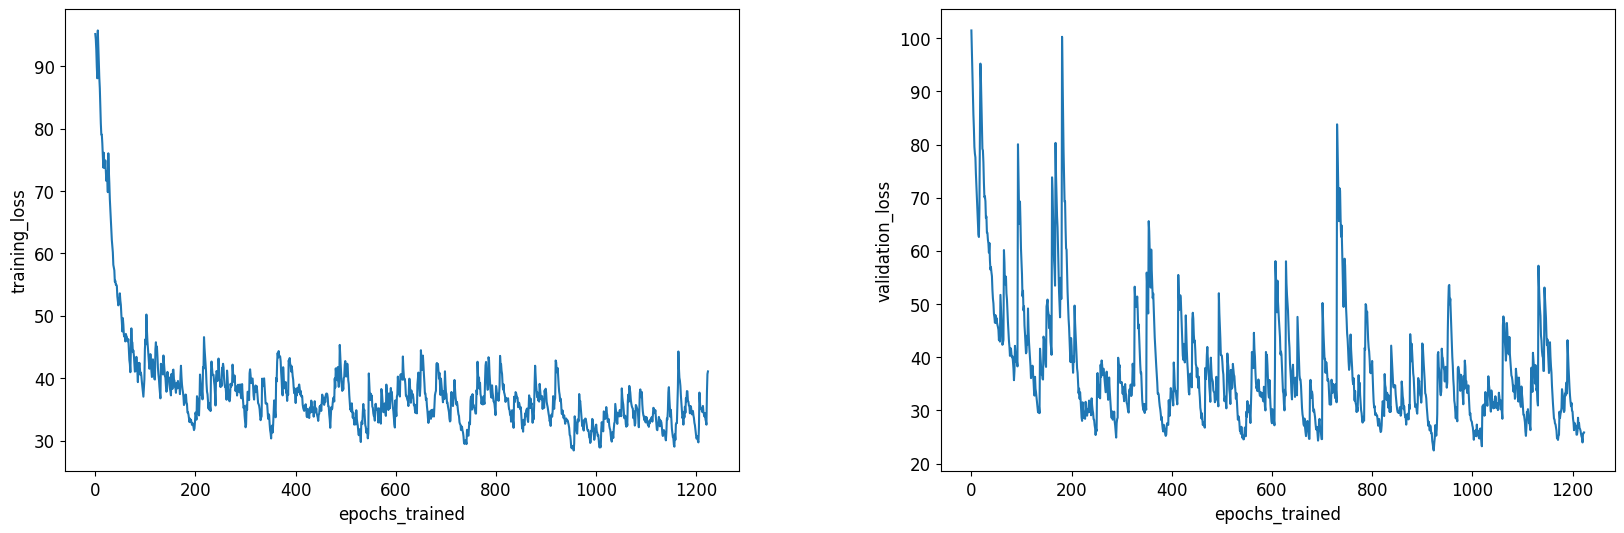

In [248]:
from sbi.analysis import plot_summary

plot_summary(inference, tags=["training_loss", "validation_loss"])

In [249]:
posterior = inference.build_posterior(score_estimator)

In [250]:
theta_true = prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)

In [251]:
from sbi.samplers.score.predictors import DDIM, EulerMaruyama 


In [258]:
samples = posterior.sample((1000,), x=x_obs, steps=100)

Drawing 1000 posterior samples:   0%|          | 0/99 [00:00<?, ?it/s]

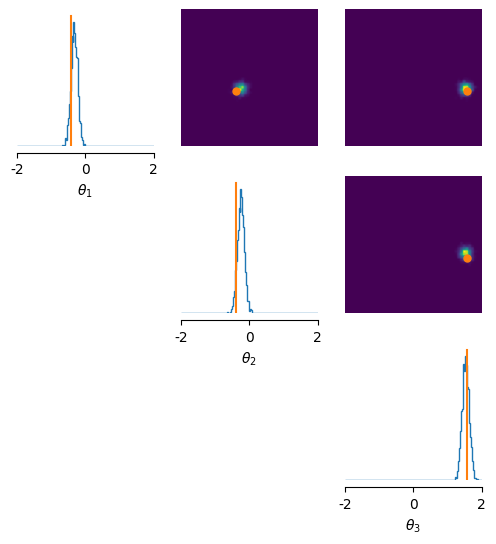

In [259]:
#samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [260]:
!pip install sbibm --no-deps

In [58]:
from sbibm.tasks import get_task

task = get_task("two_moons")

prior = task.get_prior_dist()
simulator = task.get_simulator()

thetas = prior.sample((10_000,))
xs = simulator(thetas)


In [74]:
# Create inference object. Here, NPE is used.
inference = NSPE(prior=prior, sde_type="ve")
inference = inference.append_simulations(thetas, xs)

# train the density estimator and build the posterior
score_estimator = inference.train(stop_after_epochs=500, training_batch_size=100)
posterior = inference.build_posterior(score_estimator)

 Training neural network. Epochs trained: 2830

KeyboardInterrupt: 

In [75]:
from sbi.analysis import plot_summary

_ = plot_summary(inference, tags=["training_loss", "validation_loss"])

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/root/sbi/tutorials/sbi-logs/NSPE/2024-07-18T22_49_27.875585' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: [].


KeyError: "'training_loss' is not a valid tag of the tensorboard SummaryWriter. Valid tags are: []."

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

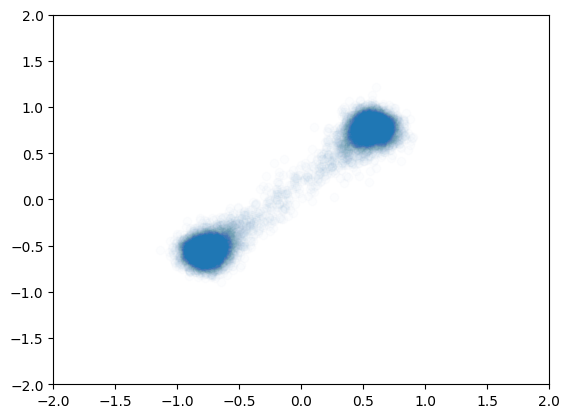

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

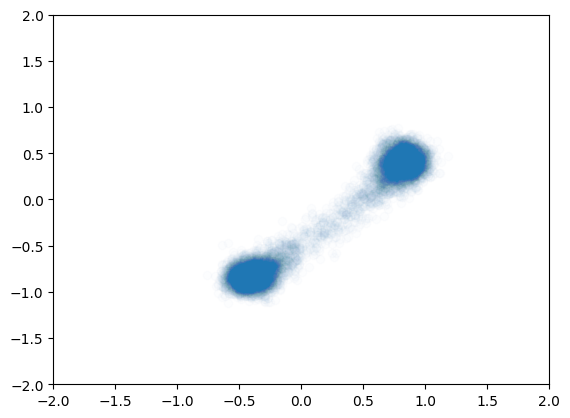

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

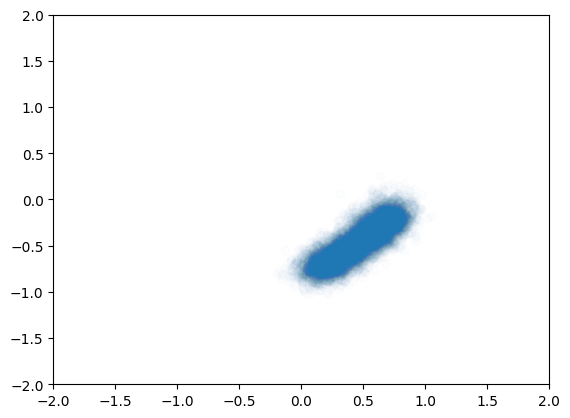

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8ae4579850>>
Traceback (most recent call last):
  File "/root/miniconda3/envs/sbi3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


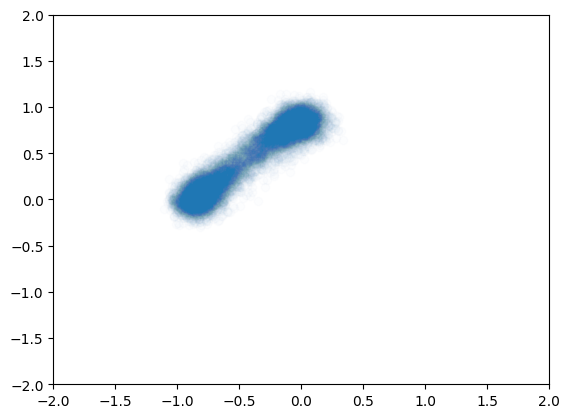

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

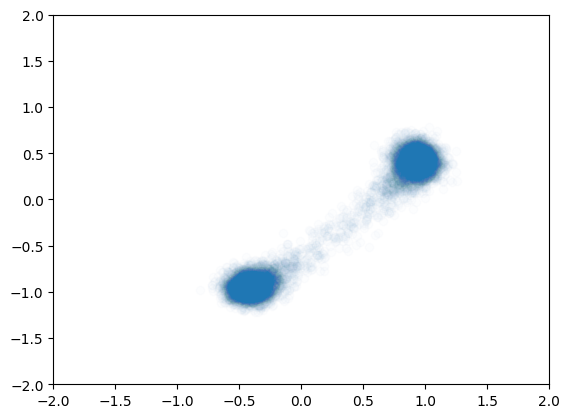

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

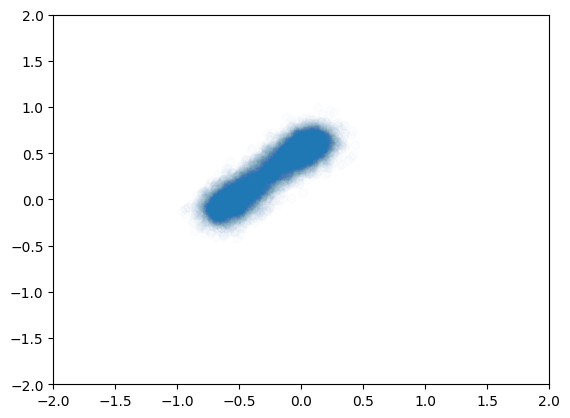

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

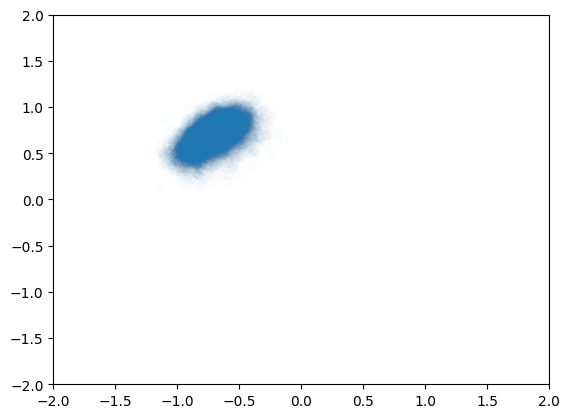

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

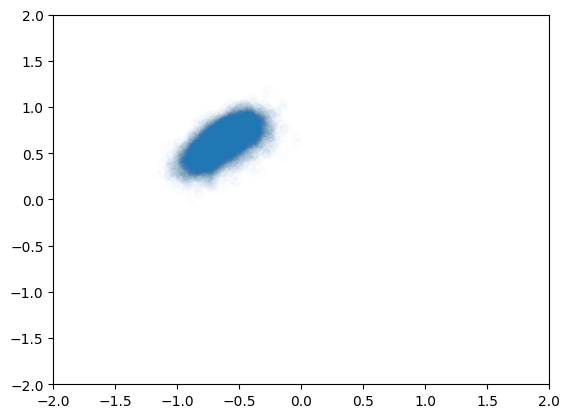

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

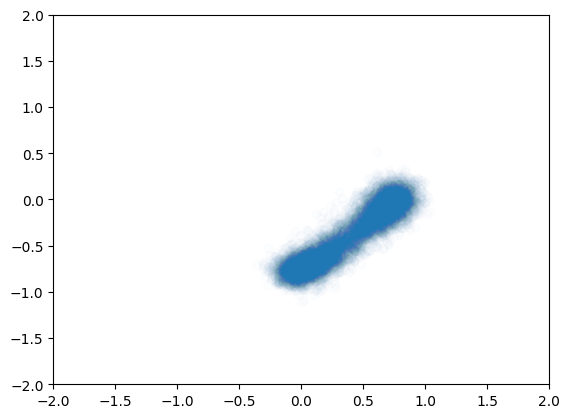

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

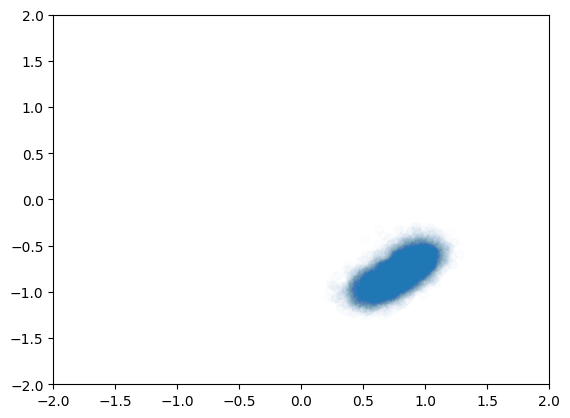

In [ ]:
from sbi.utils.metrics import c2st 
import matplotlib.pyplot as plt

for i in range(1,11):
    ref_samples = task.get_reference_posterior_samples(i)
    x_obs = task.get_observation(i)
    samples = posterior.sample((10000,), x=x_obs)
    #print(c2st(ref_samples, samples))
    plt.scatter(samples[:,0], samples[:,1], alpha=0.01)
    plt.ylim(-2,2)
    plt.xlim(-2,2)
    plt.show()